In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
from matplotlib.patches import *
import scipy.integrate.quadpack
import math
import matplotlib as mpl
import prettytable as pt

# **Вариант 3 Биржевые котировки**
# Кумирова, Харлунин, М32021

 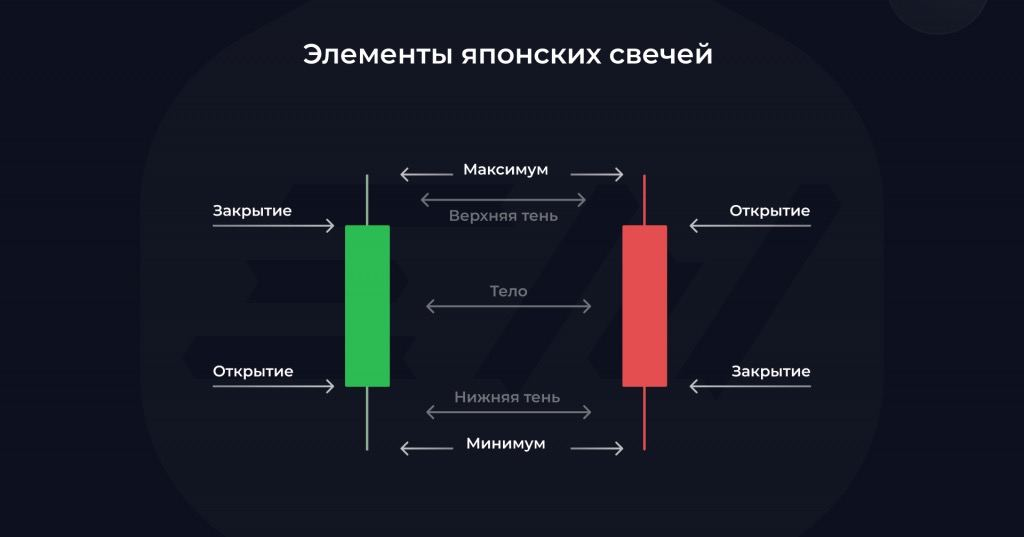

Одним из наиболее важных показателей для анализа поведения биржи явдяется минимальная цена акции за день. Этот показатель рассчитывается на различных периодах времени наравне с максимальной ценой акции за период, цене на начало и конец рассматриваемого периода, а также объёмом продаж. Все вместе эти показатели образуют знакомый многим инструмент - японские свечи.
Предположим, что аналитик разработал магический алгоритм, предсказывающий поведение акции. Результатом работы алгоритма является участок функции, который отражает движение котировок на период следующей "свечи":

$y=\sin(x) - \ln(x^2) - 1$

По данному предсказанию определите момент времени (в условных единицах), в который вы могли бы совершить покупку акций по минимальной цене.

In [2]:
mpl.style.use(['ggplot'])

In [3]:
f = lambda x_: np.sin(x_) - np.log(x_**2) - 1
x = np.linspace(-30, 30, 10**4)
y = f(x)

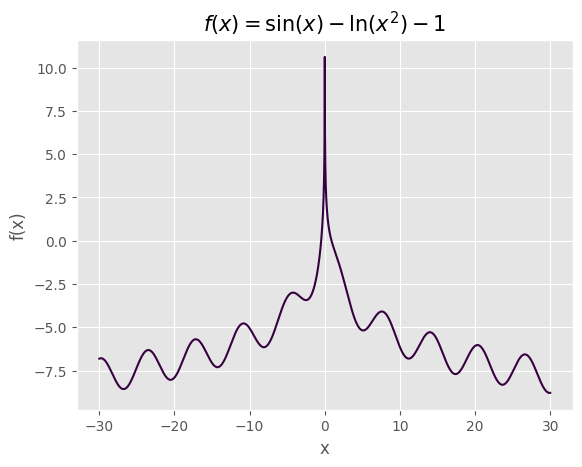

In [4]:
plt.title("$f(x) = \\sin(x) - \\ln(x^2) - 1$", fontsize=15)
plt.plot(x, y, color='xkcd:deep purple')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

Функцию $f(x)$ называют **унимодальной** на отрезке $[a,b]$, если существует такая точка $x_* \in [a,b]$, что функция $f(x)$ в полуинтервале $[a,x_*)$ убывает, а в полуинтервале $(x_*,b]$ возрастает


**Достаточное условие унимодальности:**

если функция $y=f(x)$ дважды дифференцируема на отрезке $[a,b]$ и $f^{\prime\prime}>0$ в любой точке этого отрезка, то данная функция является унимодальной на отрезке $[a,b]$

**Необходимое условие унимодальности:**

если первая производная функции $f^{\prime}$ неубывает на отрезке $[a,b]$, то функция $y=f(x)$ является унимодальной на отрезке $[a,b]$

Для того, чтобы определить интервал, на котором исходная функция является унимодальной, найдём точки перегиба. Для этого вычислим, в каких точках вторая производная функции равна $0$:

Проверим НУ унимодальности на интервале $[0,7.587]$. Для этого также найдём точки перегиба и убедимся, что функция на рассматриваемом интервале неубывает.


In [5]:
f_prime = lambda x_: np.cos(x_) - 2 / x_
x = np.linspace(-30, 30, 10**2)
y_prime = f_prime(x)

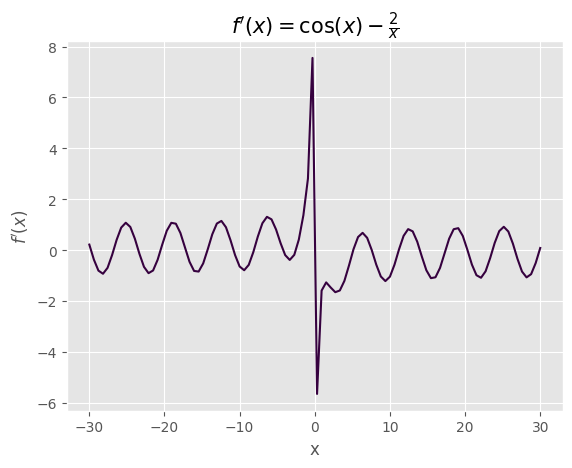

In [6]:
plt.title("$f^{\prime}(x) = \\cos(x) - \\frac{2}{x}$", fontsize=15)
plt.plot(x, y_prime, color='xkcd:deep purple')
plt.xlabel("x")
plt.ylabel("$f^{\prime}(x)$")
plt.grid(True)
plt.show()

Видим, что для интервала $[0,7.587]$ необходимое условие унимодальности не выполняется: точка $(6.333, 0.683)$ является точкой перегиба.

$5.114<6.333<7.587$, поэтому интервалом, на котором исходная функция унимодальна, будет полуинтервал $(0, 6.333]$, т.к. функция не определена в нуле

## Алгоритмы одномерной минимизации функции без производной

### Метод дихотомии

Данный итеративный метод направлен на сужение интервала неопределенности $[a_i, b_i]$.
пусть $\varepsilon$ - желаемая точность, с которой мы хотим найти минимум, тогда $\delta < \frac{\varepsilon}{2}$ - величина отступа от середины $\frac{a_i + b_i}{2}$

Во время каждой итерации значение функции вычисляется два раза: $f(x_1)$ и $f(x_2)$, где $x_1=\frac{a_i + b_i}{2}-\delta$, $x_2=\frac{a_i + b_i}{2}+\delta$

т.к. $|a_{i+1}b_{i+1}| \approx \frac{|a_ib_i|}{2}$, и после выполнения $n$ итераций $|a_{n}b_{n}| \approx \frac{|a_0b_0|}{2^n}$ то для достижения точности $\varepsilon$ потребуется $\frac{\ln\big(\frac{b_0-a_0}{\varepsilon}\big)}{\ln(2)}$ итераций

In [7]:
def dichotomy(func, a, b, eps, max_iter, drawing = False):
    if not eps:
        eps = (b - a) / 1000

    intervals = pt.PrettyTable()
    intervals.field_names = ["iteration", "a", "b", "length"]
    intervals.add_row([0, a, b, abs(b - a)])

    if drawing:
      x__ = np.linspace(a, b, int((b - a) / eps))
      y__ = func(x__)

      plt.plot(x__, y__, color='xkcd:deep purple', linewidth=2, label="$f(x)$")
      plt.xlabel("x")
      plt.ylabel("f(x)")
      plt.grid(True)

    delta = eps / 2
    ai, bi = a, b

    if drawing:
      plt.axvline(x=ai, color='xkcd:sage', ls='--', label="$a_i$")
      plt.axvline(x=bi, color='xkcd:light grey green', ls='--', label="$b_i$")
      plt.plot([ai, bi],[max(func(ai), func(bi)), max(func(ai), func(bi))],
               color='xkcd:heather', label="$[a_i, b_i]$")

    i = 0
    while abs(bi - ai) > eps:
        mid = (ai + bi) / 2
        x1, x2 = mid - delta, mid + delta
        y1, y2 = func(x1), func(x2)

        if y1 < y2:
            bi = mid
        elif y1 > y2:
            ai = mid
        else:
            ai, bi = x1, x2
        i += 1

        if i == max_iter: break

        intervals.add_row([i, ai, bi, abs(bi - ai)])

        if drawing:
          plt.plot([ai, bi],[max(func(ai), func(bi)), max(func(ai), func(bi))],
                   color='xkcd:heather')

          plt.axvline(x=ai, color='xkcd:sage', ls='--')
          plt.axvline(x=bi, color='xkcd:light grey green', ls='--')

    if drawing:
      plt.legend()
      plt.show()

      print(intervals)

    return {'x min': (ai + bi) / 2,
            'y min': func((ai + bi) / 2),
            'iterations count': i,
            'intervals': intervals,
            'computations': 2 * i}

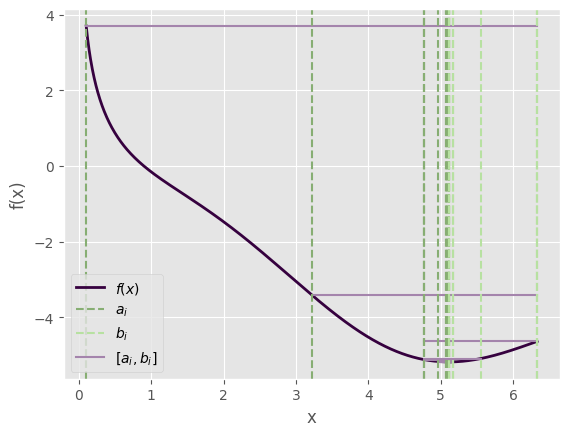

+-----------+--------------------+-------------------+-----------------------+
| iteration |         a          |         b         |         length        |
+-----------+--------------------+-------------------+-----------------------+
|     0     |        0.1         |       6.333       |   6.2330000000000005  |
|     1     |       3.2165       |       6.333       |   3.1165000000000003  |
|     2     |      4.77475       |       6.333       |   1.5582500000000001  |
|     3     |      4.77475       |      5.553875     |   0.7791249999999996  |
|     4     |      4.77475       | 5.164312499999999 |  0.38956249999999937  |
|     5     | 4.969531249999999  | 5.164312499999999 |  0.19478125000000013  |
|     6     | 5.066921874999999  | 5.164312499999999 |  0.09739062500000006  |
|     7     | 5.066921874999999  |    5.1156171875   |  0.048695312500000476 |
|     8     | 5.091269531249999  |    5.1156171875   |  0.024347656250000682 |
|     9     | 5.1034433593749995 |    5.1156171875  

{'x min': 5.114095458984375,
 'y min': -5.184396204965845,
 'iterations count': 11,
 'intervals': <prettytable.PrettyTable at 0x7b7977f42710>,
 'computations': 22}

In [8]:
dichotomy(f, 0.1, 6.333, 0.005, 500, True)

### Метод золотого сечения

Точки $x_1, \: x_2$ находятся симметрично относительно середины отрезка $[a_0, b_0]$ и делят его в пропорции золотого сечения, когда длина всего отрезка относится к длине большей его части так же, как длина большей части относится к длине меньшей части:

$\frac{b_0-a_0}{b_0-x_1} = \frac{b_0-x_1}{x_1-a_0}$

Отсюда

$x_1=a_i+\frac{\sqrt{5}-1}{2}(b_i-a_i)=a_i+0.381966011 \cdot(b_i-a_i)$

Аналогично для второй точки

За одну итерацию интервал неопределённости уменьшается в $\frac{\sqrt{5}+1}{2}=1.618..$ раз, однако на следующей итерации мы будем вычислять функцию только один раз, так как по свойству золотого сечения $\frac{x_2-x_1}{b-x_1}=0.381..$ и $\frac{b-x_2}{b-x_1}=0.618..$

Для достижения точности $\varepsilon$ потребуется $n \geq \frac{\ln\big(\frac{b_0-a_0}{\varepsilon}\big)}{\ln\big(\frac{\sqrt{5}-1}{2}\big)}$

In [9]:
def golden_ratio(func, a, b, eps, max_iter, drawing = False):
    d = abs(b - a)

    if not eps:
        eps = d / 1000

    intervals = pt.PrettyTable()
    intervals.field_names = ["iteration", "a", "b", "length"]


    if drawing:
      x__ = np.linspace(a, b, int((b - a) / eps))
      y__ = func(x__)

      plt.plot(x__, y__, color='xkcd:deep purple', linewidth=2, label="$f(x)$")
      plt.xlabel("x")
      plt.ylabel("f(x)")
      plt.grid(True)

    K = (3 - math.sqrt(5)) / 2

    x1, x2 = a + K * d, b - K * d
    y1, y2 = func(x1), func(x2)

    ai, bi = a, b
    di = d

    intervals.add_row([0, ai, bi, di])

    if drawing:
      plt.axvline(x=ai, color='xkcd:sage', ls='--', label="$a_i$")
      plt.axvline(x=bi, color='xkcd:light grey green', ls='--', label="$b_i$")
      plt.plot([ai, bi],[max(func(ai), func(bi)), max(func(ai), func(bi))],
               color='xkcd:heather', label="$[a_i, b_i]$")

    i = 0
    while (bi - ai) >= eps:
        if y2 > y1:
            bi = x2
            x2 = x1
            x1 = ai + K * (bi - ai)
            y2 = y1
            y1 = func(x1)
        else:
            ai = x1
            x1 = x2
            x2 = bi - K * (bi - ai)
            y1 = y2
            y2 = func(x2)

        i += 1

        if i == max_iter: break

        intervals.add_row([i, ai, bi, (bi - ai)])

        if drawing:
          plt.plot([ai, bi],[max(func(ai), func(bi)), max(func(ai), func(bi))],
                   color='xkcd:heather')

          plt.axvline(x=ai, color='xkcd:sage', ls='--')
          plt.axvline(x=bi, color='xkcd:light grey green', ls='--')

    if drawing:
      plt.legend()
      plt.show()
      print(intervals)

    return {'x min': (ai + bi) / 2, 'y min': func((ai + bi) / 2),
            'iterations count': i,
            'intervals': intervals,
            'computations': i + 2} # two computations for i = 0

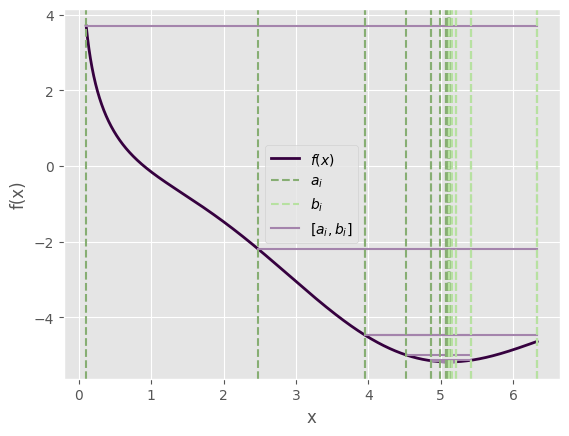

+-----------+--------------------+--------------------+------------------------+
| iteration |         a          |         b          |         length         |
+-----------+--------------------+--------------------+------------------------+
|     0     |        0.1         |       6.333        |   6.2330000000000005   |
|     1     | 2.4807941481219054 |       6.333        |   3.852205851878095    |
|     2     | 3.952205851878095  |       6.333        |   2.3807941481219053   |
|     3     | 3.952205851878095  | 5.4236175556342845 |   1.4714117037561896   |
|     4     | 4.514235111268568  | 5.4236175556342845 |   0.9093824443657166   |
|     5     | 4.861588296243811  | 5.4236175556342845 |   0.5620292593904734   |
|     6     | 4.861588296243811  | 5.208941481219055  |  0.34735318497524403   |
|     7     | 4.994265406803825  | 5.208941481219055  |   0.2146760744152303   |
|     8     | 5.076264370659041  | 5.208941481219055  |  0.13267711056001374   |
|     9     | 5.076264370659

{'x min': 5.11418228829147,
 'y min': -5.184396208714908,
 'iterations count': 28,
 'intervals': <prettytable.PrettyTable at 0x7b7977e53c40>,
 'computations': 30}

In [10]:
golden_ratio(f, 0.1, 6.333, 0.00001, 500, True)

По сравнению с методом дихотомии, метод золотого сечения позволяет вычислить значение целевой функции только 1 раз за итерацию (это важно, в случае, если вычисление трудозатратно), однако данный метод сходится медленнее

### Метод Фиббоначи

>
Это улучшение реализации поиска с помощью золотого сечения, служащего для нахождения экстремума функции.
>
Подобно методу золотого сечения, он требует двух вычислений функции на первой итерации, а на каждой последующей только по одному. Однако этот метод отличается от метода золотого сечения тем, что коэффициент сокращения интервала неопределенности меняется от итерации к итерации.
>
Предположим, нам нужно определить минимум как можно точнее, т.е. с наименьшим интервалом неопределенности, но при этом можно произвести только $n$ вычислений функции.

Пусть у нас есть интервал неопределенности $(x_1,x_3)$, и нам известно значение функции $f(x_2)$, $x_2 \in (x_1, x_3)$

Если можно вычислить функцию всего один раз в точке $x_4$, то где следует ее поместить, чтобы получить минимально возможный интервал неопределенности? Заранее нам не известно, как ведет себя функция, и реализуется одна из двух ситуаций: $x_4 \in (x_1,x_2)$ или $x_4 \in (x_2,x_3)$

Т.е. неизвестно, какая из ситуаций будет иметь место, выберем $x_4$ таким образом, чтобы минимизировать максимальную из длин
- $\min{\{\max{(x_3-x_4),(x_2-x_1)}\}}$


Достигнуть этого можно, сделав эти длины равными, т.е.

- $(x_3-x_4)=(x_2-x_1)$


Для этого нужно поместить $x_4$ внутрь интервала $(x_1, x_2)$ симметрично относительно точки $x_2$.
Если окажется, что можно выполнить еще одно вычисление функции, то следует применить описанную процедуру к новому интервалу неопределенности.
Стратегия ясна: нужно поместить следующую точку внутрь интервала симметрично уже находящейся там точки.
На $n$-ом вычислении $n$-ю точку стоит поместить симметрично по отношению к $(n-1)$-й точке. Чтобы получить наибольшее уменьшение интервала на данном этапе, следует разделить пополам предыдущий интервал


Обозначим за $\epsilon$ минимальную длину интервала неопределенности. Тогда
- $L_{n-1}=2L_n-\epsilon$
- $L_{n-2}=L_{n-1}+L_n$

Числа Фибоначчи определяются соотношениями:
- $F_{n+1}=F_{n+1}+F_n$
- $n=1,2,...,$
- $F_1=F_2 \;\; (=1)$

In [11]:
def get_fib_by_number(n):
  fibs = (1, 1)
  if n < 2:
    return fibs[n]

  for i in range(2, n):
    fibs = fibs[1], fibs[0] + fibs[1]

  return fibs[1]


In [12]:
def get_number_by_fib(fib):
  if fib <= 1:
    return 2

  i = 2
  fibs = (1, 1)

  while True:
    fibs = fibs[1], fibs[0] + fibs[1]
    i += 1
    if fibs[1] >= fib:
      return i

На начальном интервале вычисляются точки
- $x_1 = a_0+\frac{F_n}{F_{n+2}}(b_0-a_0)$
- $x_2 = a_0+\frac{F_{n+1}}{F_{n+2}}(b_0-a_0)$


где $n$ выбирается исходя из точности и начальной длины интервала.

In [13]:
def fibonacci_method(func, a, b, eps, max_iter, drawing = False):

    fib_iters = (b - a) / eps
    n = get_number_by_fib(fib_iters) - 2

    x1 = a + get_fib_by_number(n) / get_fib_by_number(n + 2) * (b - a)
    x2 = a + get_fib_by_number(n + 1) / get_fib_by_number(n + 2) * (b - a)
    y1 = func(x1)
    y2 = func(x2)

    ai, bi = a, b

    intervals = pt.PrettyTable()
    intervals.field_names = ["iteration", "a", "b", "length"]
    intervals.add_row([0, ai, bi, bi - ai])
    intervals.add_row([1, ai, bi, bi - ai])

    if drawing:
      x__ = np.linspace(a, b, int((b - a) / eps))
      y__ = func(x__)

      plt.plot(x__, y__, color='xkcd:deep purple', linewidth=2, label="$f(x)$")
      plt.xlabel("x")
      plt.ylabel("f(x)")
      plt.grid(True)

    for k in range(2, n + 3):
        if y1 > y2:
            ai = x1
            x1, y1 = x2, y2
            x2 = ai + get_fib_by_number(n - k + 2) / get_fib_by_number(n - k + 3) * (bi - ai)
            y2 = func(x2)
        else:
            bi = x2
            x2, y2 = x1, y1
            x1 = ai + get_fib_by_number(n - k + 1) / get_fib_by_number(n - k + 3) * (bi - ai)
            y1 = func(x1)

        if drawing:
          plt.plot([ai, bi],[max(func(ai), func(bi)), max(func(ai), func(bi))],
                   color='xkcd:heather')

          plt.axvline(x=ai, color='xkcd:sage', ls='--')
          plt.axvline(x=bi, color='xkcd:light grey green', ls='--')

        intervals.add_row([k, ai, bi, bi - ai])


    if drawing:
      plt.legend()
      plt.show()
      print(intervals)

    return {'x min': (ai + bi) / 2, 'y min': func((ai + bi) / 2),
            'iterations count': n,
            'intervals': intervals,
            'computations': n + 2} # two computations for i = 0

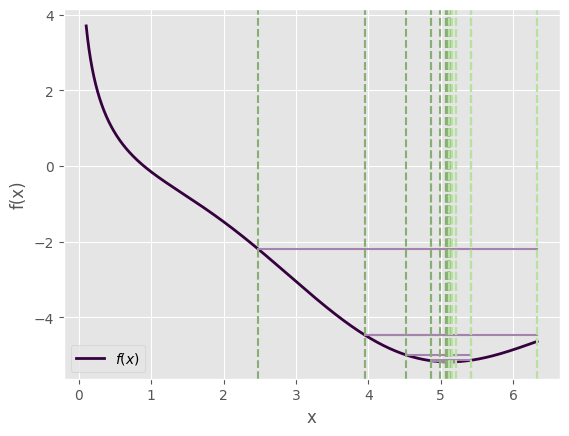

+-----------+--------------------+--------------------+------------------------+
| iteration |         a          |         b          |         length         |
+-----------+--------------------+--------------------+------------------------+
|     0     |        0.1         |       6.333        |   6.2330000000000005   |
|     1     |        0.1         |       6.333        |   6.2330000000000005   |
|     2     | 2.4807941481178792 |       6.333        |   3.852205851882121    |
|     3     | 3.9522058518821215 |       6.333        |   2.3807941481178787   |
|     4     | 3.9522058518821215 | 5.423617555646364  |   1.4714117037642422   |
|     5     | 4.514235111292727  | 5.423617555646364  |   0.9093824443536365   |
|     6     | 4.861588296235758  | 5.423617555646364  |   0.5620292594106058   |
|     7     | 4.861588296235758  | 5.2089414811787895 |   0.3473531849430316   |
|     8     | 4.994265406711216  | 5.2089414811787895 |   0.2146760744675733   |
|     9     | 5.076264370703

{'x min': 5.1141812130426425,
 'y min': -5.184396208714439,
 'iterations count': 28,
 'intervals': <prettytable.PrettyTable at 0x7b7977473e80>,
 'computations': 30}

In [14]:
fibonacci_method(f, 0.1, 6.333, 0.00001, 500, True)

Метод Фиббоначи по своей сути является улучшением метода золотого сечения и позволяет определить, сколько итераций потребуется для нахождения минимума с заданной точностью

### Метод парабол

В методе парабол предлагается аппроксимировать оптимизируемую функцию $f(x)$ с помощью квадратичной функции
$p(x)=ax^2+bx+c$

Пусть имеются три точки $x_1 < x_2 < x_3$ такие, что интервал $[x_1, x_3]$ содержит точку минимума функции $f$. Тогда коэффициенты $a, \:b, \:c$ аппроксимирующей параболы могут быть найдены путём решения системы линейных уравнений:
$ax_i^2+bx_i+c=f_i=f(x_i), \; i=1, \: 2, \:3$

Минимум такой параболы равен
$u=-\frac{b}{2a}=x_2-\frac{(x_2-x_1)^2(f_2-f_3)-(x_2-x_3)^2(f_2-f_1)}{2[(x_2-x_1)(f_2-f_3)-(x_2-x_3)(f_2-f_1)]}$

Если $f_2<f_1$ и $f_2<f_3$, то точка $u$ гарантированно попадёт в интервал $[x_1, x_3]$. Таким образом, внутри интервала $[x_1, x_3]$ определены две точки $x_2$ и $u$, с помощью сравнения значений функции $f$ в которых можно сократить интервал поиска.


In [15]:
def successive_parabolic_interpolation(f, a, b, epsilon, max_iter, drawing = False):
    x1, x3, x2 = a, b, (a + b) / 2

    f1 = f(x1)
    f2 = f(x2)
    f3 = f(x3)
    f_x = {x1: f1, x2: f2, x3: f3}

    counter = 3

    intervals = pt.PrettyTable()
    intervals.field_names = ["iteration", "a", "b", "length"]
    intervals.add_row([0, x1, x3, abs(x3 - x1)])

    if drawing:
        x__ = np.linspace(a, b, int((b - a) / epsilon))
        y__ = f(x__)

        plt.plot(x__, y__, color='xkcd:deep purple', linewidth=2, label="$f(x)$")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.grid(True)

        plt.axvline(x=x1, color='xkcd:sage', ls='--', label="$a_i$")
        plt.axvline(x=x3, color='xkcd:light grey green', ls='--', label="$b_i$")
        plt.plot([x1, x3], [max(f(x1), f(x3)), max(f(x1), f(x3))],
                 color='xkcd:heather', label="$[a_i, b_i]$")

    x2, x3, x1 = sorted([x1, x3, x2], key=lambda x: f_x[x])

    try:
        for i in range(1, max_iter):
            f1, f2, f3 = f_x[x1], f_x[x2], f_x[x3]
            p = (x2 - x1) ** 2 * (f2 - f3) - (x2 - x3) ** 2 * (f2 - f1)
            q = 2 * ((x2 - x1) * (f2 - f3) - (x2 - x3) * (f2 - f1))

            assert p != 0, 'Searching finished. Numerator is zero. code 2'
            assert q != 0, 'Searching finished. Denominator is zero. code 2'

            u = x2 - p / q

            if not a <= u <= b:
                print('Searching finished. Out of bounds. code 1')
                return {'x min': x2, 'y min': f2, 'iterations count': i,
                        'intervals': intervals, 'computations': counter}

            fu = f(u)
            f_x[u] = fu
            previous_xs = [x1, x2, x3]

            counter +=1

            if fu < f2:
                x1, f1 = x3, f3
                x3, f3 = x2, f2
                x2, f2 = u, fu

            elif fu < f3:
                x1, f1 = x3, f3
                x3, f3 = u, fu

            elif fu < f1:
                x1, f1 = u, fu

            intervals.add_row([i, min(x1, x3), max(x1, x3), abs(x3 - x1)])

            change_flag = max(map(lambda x, y: abs(x - y),
            [x1, x2, x3], previous_xs)) < epsilon

            if drawing:
                plt.plot([x1, x3], [max(f(x1), f(x3)), max(f(x1), f(x3))],
                         color='xkcd:heather')

                plt.axvline(x=min(x1, x3), color='xkcd:sage', ls='--')
                plt.axvline(x=max(x1, x3), color='xkcd:light grey green', ls='--')

            if abs(x3 - x1) < epsilon and abs(f3 - f1) < epsilon or change_flag:
                if drawing:
                  plt.legend()
                  plt.show()
                  print('Searching finished successfully. code 0')
                  print(intervals)
                return {'x min': x2, 'y min': f2, 'iterations count': i,
                        'intervals': intervals, 'computations': counter}

        else:
            print('Searching finished. Max iterations have been reached. code 1')
            return {'x min': x2, 'y min': f2, 'iterations count': i,
                    'intervals': intervals, 'computations': counter}

    except Exception as e:
        print('Error with optimization. code 2')
        raise e

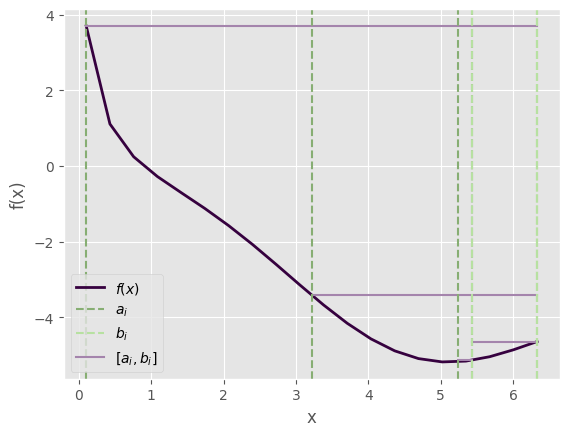

Searching finished successfully. code 0
+-----------+-------------------+-------------------+---------------------+
| iteration |         a         |         b         |        length       |
+-----------+-------------------+-------------------+---------------------+
|     0     |        0.1        |       6.333       |  6.2330000000000005 |
|     1     |       3.2165      |       6.333       |  3.1165000000000003 |
|     2     | 5.426169606718018 |       6.333       |  0.9068303932819823 |
|     3     | 5.237571253895454 | 5.426169606718018 | 0.18859835282256388 |
+-----------+-------------------+-------------------+---------------------+


{'x min': 5.005156131428065,
 'y min': -5.178386149572577,
 'iterations count': 3,
 'intervals': <prettytable.PrettyTable at 0x7b79771a7b80>,
 'computations': 6}

In [16]:
successive_parabolic_interpolation(f, 0.1, 6.333, 0.3, 500, True)

В отличие от метода золотого сечения, метод парабол обладает суперлинейной скоростью сходимости. Однако, такая высокая скорость сходимости гарантируется только в малой окрестности точки минимума $x_{\min}$. На начальных стадиях процесса оптимизации метод парабол может делать очень маленькие шаги или, наоборот, слишком большие шаги, приводящие к неустойчивым биениям. Также следует отметить, что на первой итерации метод парабол требует измерения значений функции в крайних точках интервала оптимизации. Кроме этого, сходимость метода не гарантируется, т.к. начальное приближение может не попасть в окрестность точки минимума.

### Комбинированный метод Брента

Метод Брента эффективно комбинирует метод золотого сечения и метод парабол. В данном методе на каждой итерации отслеживаются значения в шести точках (не обязательно различных): $a,c,x,w,v,u$

Точки $a,c$ задают текущий интервал поиска решения,

$x$ – точка, соответствующая наименьшему значению функции,

$w$ – точка, соответветствующая второму снизу значению функции,

$v$ – предыдущее значение $w$

В отличие от метода парабол, в методе Брента аппроксимирующая парабола строится с помощью трех наилучших точек $x, w, v $ (в случае, если эти три точки различны и значения в них также различны)

При этом минимум аппроксимирующей параболы $u$ принимается в качестве следующей точки оптимизационного процесса, если:

*   $u$ попадает внутрь интервала $[a, c]$ и отстоит от границ интервала не менее, чем на $\varepsilon$
*   $u$ отстоит от точки $x$ не более, чем на половину от длины предпредыдущего шага

Если точка $u$ отвергается, то следующая точка находится с помощью золотого сечения большего из интервалов $[a, x]$ и $[x, c]$

In [17]:
def brent(f, a, c, epsilon, max_iter, drawing = False):
    K = (3 - math.sqrt(5)) / 2

    x = w = v = (a + c) / 2
    f_x = f_w = f_v = f(x)
    d = e = c - a

    counter = 0
    counter += 1

    intervals = pt.PrettyTable()
    intervals.field_names = ["iteration", "a", "b", "length"]
    intervals.add_row([0, a, c, d])

    if drawing:
        x__ = np.linspace(a, c, int((c - a) / epsilon))
        y__ = f(x__)

        plt.plot(x__, y__, color='xkcd:deep purple',
                 linewidth=2, label="$f(x)$")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.grid(True)

        plt.axvline(x=a, color='xkcd:sage', ls='--', label="$a_i$")
        plt.axvline(x=c, color='xkcd:light grey green', ls='--', label="$b_i$")
        plt.plot([a, c], [max(f(a), f(c)), max(f(a), f(c))],
                 color='xkcd:heather', label="$[a_i, b_i]$")

    try:
        for i in range(1, max_iter):
            g, e = e, d

            unique = np.unique([x, w, v, f_x, f_w, f_v])
            if len([x, w, v, f_x, f_w, f_v]) == len(unique):
                p = (x - v) ** 2 * (f_x - f_w) - (x - w) ** 2 * (f_x - f_v)
                q = 2 * ((x - v) * (f_x - f_w) - (x - w) * (f_x - f_v))

                assert p != 0, 'Searching finished. Numerator is zero. code 2'
                assert q != 0, 'Searching finished. Denominator is zero. code 2'

                u = x - p / q

                if d <= epsilon:
                  if drawing:
                      plt.legend()
                      plt.show()
                      intervals.add_row([i, min(u, x), max(u, x), d])
                      print('Searching finished successfully. code 0')
                      print(intervals)
                  return {'x min': x, 'y min': f_x, 'iterations count': i,
                          'intervals': intervals, 'computations': counter}

                if a + epsilon <= u <= c - epsilon and abs(u - x) < g / 2:
                    d = abs(u - x)
                    intervals.add_row([i, a, c, c - a])
                    if drawing:
                      plt.plot([a, c], [max(f(a), f(c)), max(f(a), f(c))],
                               color='xkcd:heather')

                      plt.axvline(x=a, color='xkcd:sage', ls='--')
                      plt.axvline(x=c, color='xkcd:light grey green', ls='--')
                    continue

            if x < (c + a) / 2:
                u = x + K * (c - x)
                d = c - x
            else:
                u = x - K * (x - a)
                d = x - a

            if abs(u - x) < epsilon:
                u = x + np.sign(u - x) * epsilon

            f_u = f(u)

            counter += 1

            if f_u <= f_x:
                if u >= x:
                    a = x
                else:
                    c = x

                v, f_v = w, f_w
                w, f_w = x, f_x
                x, f_x = u, f_u

            else:
                if u >= x:
                    c = u
                else:
                    a = u

                if f_u <= f_w or w == x:
                    v, f_v = w, f_w
                    w, f_w = u, f_u
                elif f_u <= f_v or v == x or v == w:
                    v, f_v = u, f_u

            intervals.add_row([i, a, c, d])

            if drawing:
              plt.plot([a, c], [max(f(a), f(c)), max(f(a), f(c))],
                       color='xkcd:heather')

              plt.axvline(x=a, color='xkcd:sage', ls='--')
              plt.axvline(x=c, color='xkcd:light grey green', ls='--')

        else:
            print('Searching finished. Max iterations have been reached. code 1')
            return {'x min': x, 'y min': f_x, 'iterations count': i,
                    'intervals': intervals, 'computations': counter}

    except Exception as e:
        print('Error with optimization. code 2')
        raise e


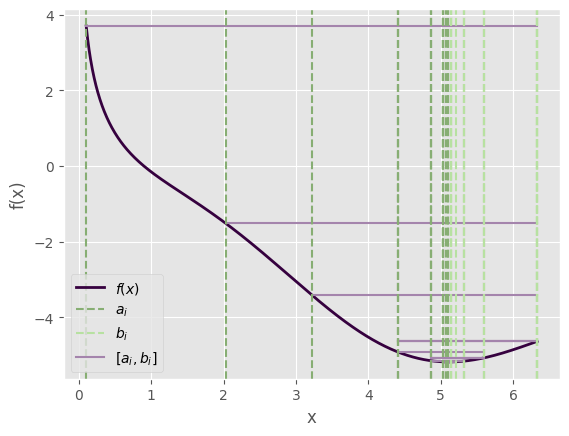

Searching finished successfully. code 0
+-----------+--------------------+-------------------+-----------------------+
| iteration |         a          |         b         |         length        |
+-----------+--------------------+-------------------+-----------------------+
|     0     |        0.1         |       6.333       |   6.2330000000000005  |
|     1     | 2.0261029259390475 |       6.333       |         3.1165        |
|     2     |       3.2165       |       6.333       |   3.1165000000000003  |
|     3     | 4.406897074060953  |       6.333       |   1.9261029259390474  |
|     4     | 4.406897074060953  |       6.333       |   1.9261029259390474  |
|     5     | 4.406897074060953  |       6.333       |   1.9261029259390474  |
|     6     | 4.406897074060953  | 5.597294148121906 |   1.1903970740609529  |
|     7     | 4.861588296243811  | 5.597294148121906 |   0.7357058518780946  |
|     8     | 4.861588296243811  | 5.597294148121906 |   0.7357058518780946  |
|     9     

{'x min': 5.117263852586649,
 'y min': -5.1843914775006334,
 'iterations count': 21,
 'intervals': <prettytable.PrettyTable at 0x7b79770f1d50>,
 'computations': 12}

In [18]:
brent(f, 0.1, 6.333, 0.005, 500, True)

Мы избегаем биений и застопориваний метода парабол, используя гарантированно сходящийся метод Золотого сечения в невыгодных ситуациях. И при этом при хороших значениях вершины параболы у нас получается использовать суперлинейную скорость сходимости метода Брента. В отличие от метода парабол метод Брента обладает гарантированной сходимостью.

## Сравнение методов по количеству итераций и вызову функций

In [19]:
def optimize(f, a, b, epsilon, max_iter, delta):
    methods = np.array([
        brent,
        successive_parabolic_interpolation,
        fibonacci_method,
        golden_ratio,
        dichotomy
        ])
    results = {}
    for met in methods:
        computations = []
        epsilons = []
        iterations = []

        epsilon_i = epsilon
        delta_i = delta
        while epsilon_i - delta_i >= 0:
            res = met(f, a, b, epsilon_i, max_iter)
            epsilons.append(epsilon_i)
            epsilon_i -= delta_i
            computations.append(res["computations"])
            iterations.append(res["iterations count"])

        results[met.__name__] = (epsilons, computations, iterations)

    return results

In [20]:
values = optimize(f, 0.1, 6.333, 0.5, 500, 0.001)

In [21]:
colors = {
    'brent' : 'xkcd:sage',
    'successive_parabolic_interpolation' : 'xkcd:light grey green',
    'fibonacci_method' : 'xkcd:heather',
    'golden_ratio' : 'xkcd:plum',
    'dichotomy' : 'xkcd:deep purple',
}

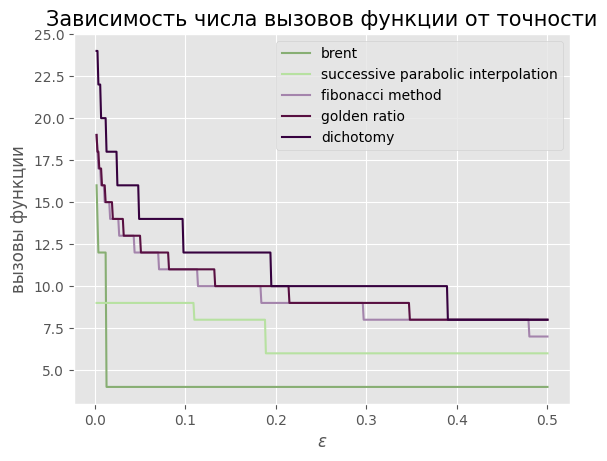

In [22]:
for method_name in values.keys():
  plt.plot(values[method_name][0], values[method_name][1],
          label = method_name.replace('_', ' '), color=colors.get(method_name))

plt.title("Зависимость числа вызовов функции от точности", fontsize = 15)
plt.xlabel("$\epsilon$")
plt.ylabel("вызовы функции")
plt.legend()
plt.grid(True)
plt.show()

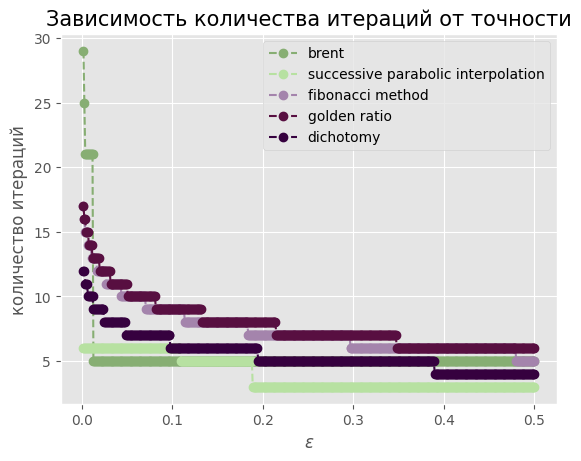

In [23]:
for method_name in values.keys():
  plt.plot(values[method_name][0], values[method_name][2],
           'o--', label=method_name.replace('_', ' '), color=colors.get(method_name))

plt.title("Зависимость количества итераций от точности", fontsize = 15)
plt.xlabel("$\epsilon$")
plt.ylabel("количество итераций")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def get_intervals(f, a, b, epsilon, max_iter):
    methods = np.array([
    brent,
    successive_parabolic_interpolation,
    fibonacci_method,
    golden_ratio,
    dichotomy
    ])

    for met in methods:
        res = met(f, a, b, epsilon, max_iter)

        iterations = res["intervals"].get_string(fields=["iteration"],
                                     header=False, border=False).split("\n")
        iterations = list(map(int, iterations))

        length = res["intervals"].get_string(fields=["length"],
                                 header=False, border=False).split("\n")
        length = list(map(float, length))

        plt.plot(iterations, length, label=met.__name__.replace('_', ' '),
                 color=colors.get(met.__name__))

    plt.title("Зависимость длины интервала от номера итерации", fontsize = 15)
    plt.xlabel("номер итерации")
    plt.ylabel("длина интервала")
    plt.legend()
    plt.grid(True)
    plt.show()

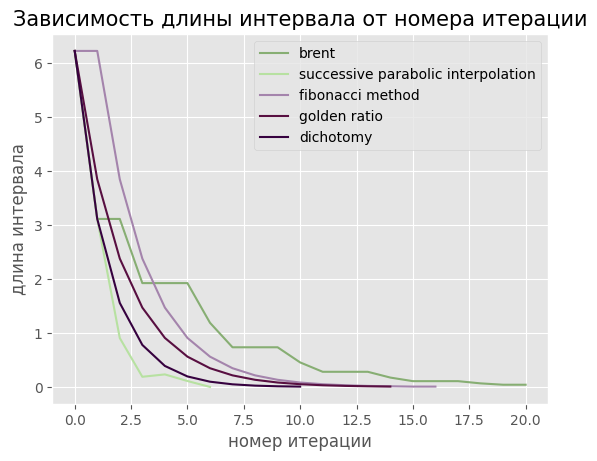

In [25]:
get_intervals(f, 0.1, 6.333, 0.01, 500)

## Тестирование алгоритмов для задач минимизации многомодальных функций

#### Метод дихотомии

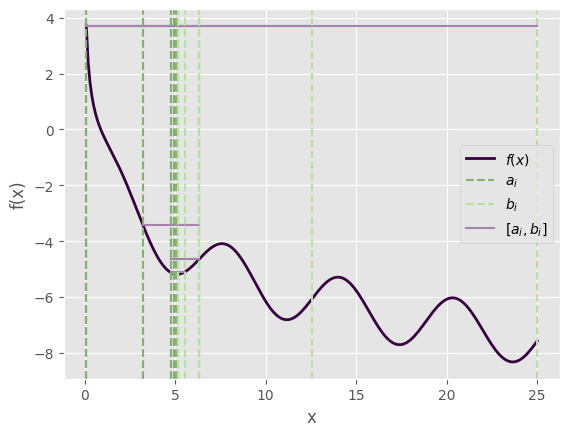

+-----------+-------------+-----------+---------------------+
| iteration |      a      |     b     |        length       |
+-----------+-------------+-----------+---------------------+
|     0     |     0.1     |     25    |         24.9        |
|     1     |     0.1     |   12.55   |  12.450000000000001 |
|     2     |     0.1     |   6.325   |  6.2250000000000005 |
|     3     |    3.2125   |   6.325   |  3.1125000000000003 |
|     4     |   4.76875   |   6.325   |  1.5562500000000004 |
|     5     |   4.76875   |  5.546875 |  0.7781250000000002 |
|     6     |   4.76875   | 5.1578125 | 0.38906250000000053 |
|     7     |  4.96328125 | 5.1578125 |  0.1945312500000007 |
|     8     | 5.060546875 | 5.1578125 | 0.09726562500000036 |
+-----------+-------------+-----------+---------------------+


{'x min': 5.1091796875,
 'y min': -5.184383727129394,
 'iterations count': 8,
 'intervals': <prettytable.PrettyTable at 0x7b79773890f0>,
 'computations': 16}

In [26]:
dichotomy(f, 0.1, 25, 0.1, 500, True)

#### Метод золотого сечения

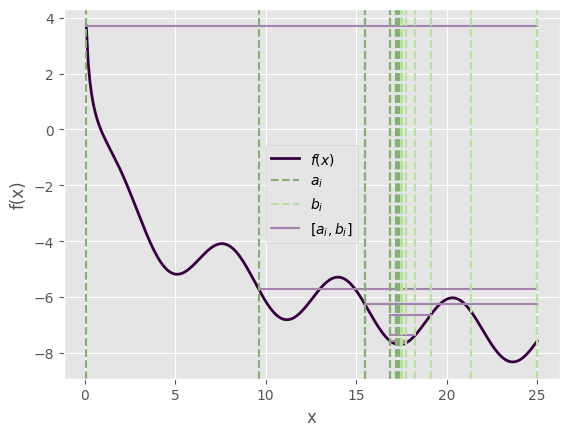

+-----------+--------------------+--------------------+---------------------+
| iteration |         a          |         b          |        length       |
+-----------+--------------------+--------------------+---------------------+
|     0     |        0.1         |         25         |         24.9        |
|     1     | 9.610953680127617  |         25         |  15.389046319872383 |
|     2     | 15.489046319872383 |         25         |  9.510953680127617  |
|     3     | 15.489046319872383 | 21.367138959617147 |  5.878092639744764  |
|     4     | 15.489046319872383 | 19.121907360255236 |  3.6328610403828527 |
|     5     | 16.876675760893328 | 19.121907360255236 |  2.245231599361908  |
|     6     | 16.876675760893328 | 18.264305201914272 |  1.3876294410209447 |
|     7     | 16.876675760893328 | 17.73427791923429  |  0.8576021583409634 |
|     8     | 17.204250636554306 | 17.73427791923429  |  0.5300272826799848 |
|     9     | 17.204250636554306 | 17.531825512215285 | 0.327574

{'x min': 17.415830604649734,
 'y min': -7.70537966343633,
 'iterations count': 12,
 'intervals': <prettytable.PrettyTable at 0x7b79773f2e90>,
 'computations': 14}

In [27]:
golden_ratio(f, 0.1, 25, 0.1, 500, True)

#### Метод фиббоначи

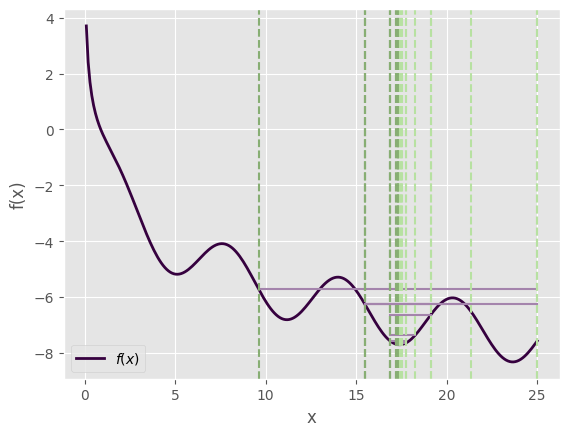

+-----------+--------------------+--------------------+---------------------+
| iteration |         a          |         b          |        length       |
+-----------+--------------------+--------------------+---------------------+
|     0     |        0.1         |         25         |         24.9        |
|     1     |        0.1         |         25         |         24.9        |
|     2     | 9.610875331564985  |         25         |  15.389124668435015 |
|     3     | 15.48912466843501  |         25         |   9.51087533156499  |
|     4     | 15.48912466843501  | 21.367374005305038 |  5.878249336870027  |
|     5     | 15.48912466843501  | 19.121750663129973 |  3.632625994694962  |
|     6     | 16.876127320954904 | 19.121750663129973 |  2.245623342175069  |
|     7     | 16.876127320954904 |  18.2631299734748  |  1.3870026525198966 |
|     8     | 16.876127320954904 | 17.734748010610076 |  0.8586206896551722 |
|     9     | 17.206366047745355 | 17.734748010610076 |  0.52838

{'x min': 17.371485411140583,
 'y min': -7.705364225881379,
 'iterations count': 12,
 'intervals': <prettytable.PrettyTable at 0x7b7977fa1540>,
 'computations': 14}

In [28]:
fibonacci_method(f, 0.1, 25, 0.1, 500, True)

#### Метод парабол

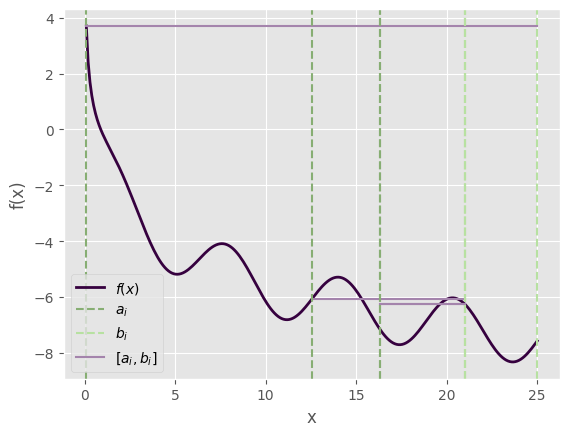

Searching finished successfully. code 0
+-----------+-------------------+-------------------+-------------------+
| iteration |         a         |         b         |       length      |
+-----------+-------------------+-------------------+-------------------+
|     0     |        0.1        |         25        |        24.9       |
|     1     |       12.55       | 21.02008379898718 |  8.47008379898718 |
|     2     | 16.32865168195062 | 21.02008379898718 | 4.691432117036559 |
|     3     | 16.32865168195062 | 21.02008379898718 | 4.691432117036559 |
+-----------+-------------------+-------------------+-------------------+


{'x min': 25,
 'y min': -7.570103399834174,
 'iterations count': 3,
 'intervals': <prettytable.PrettyTable at 0x7b797a13a890>,
 'computations': 6}

In [29]:
successive_parabolic_interpolation(f, 0.1, 25, 0.1, 500, True)

#### Комбинированный метод Брента

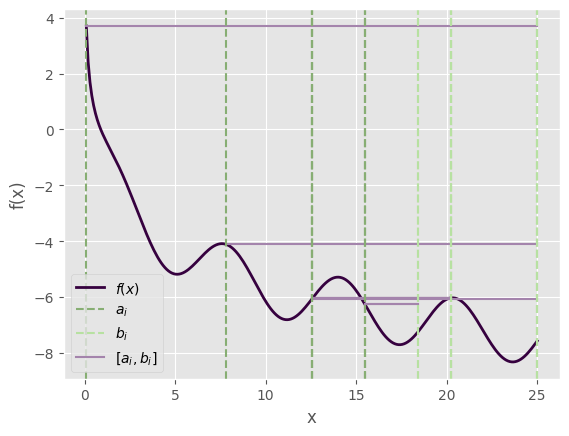

Searching finished successfully. code 0
+-----------+--------------------+--------------------+----------------------+
| iteration |         a          |         b          |        length        |
+-----------+--------------------+--------------------+----------------------+
|     0     |        0.1         |         25         |         24.9         |
|     1     | 7.794523159936192  |         25         |  12.450000000000001  |
|     2     |       12.55        |         25         |        12.45         |
|     3     |       12.55        | 20.244523159936193 |  7.694523159936189   |
|     4     |       12.55        | 20.244523159936193 |  7.6945231599361925  |
|     5     |       12.55        | 20.244523159936193 |  7.6945231599361925  |
|     6     | 15.489046319872383 | 20.244523159936193 |   4.75547684006381   |
|     7     | 15.489046319872383 | 18.428092639744765 |  2.939046319872382   |
|     8     | 15.489046319872383 | 18.428092639744765 |  2.939046319872382   |
|     9     

{'x min': 17.30547684006381,
 'y min': -7.701689179137533,
 'iterations count': 9,
 'intervals': <prettytable.PrettyTable at 0x7b79770f1870>,
 'computations': 6}

In [30]:
brent(f, 0.1, 25, 0.1, 500, True)

#### Выводы
Методы показывают себя по разному на многомодальных функциях. Наличие нескольких минимумов не повлияло на сходимость методов деления отрезка, однако выбранный ими ответ различается. Метод Брента, в отличие от метода парабол, сошелся и на многомодальной функции.

## Итоги

В работе были рассмотрены различные методы одномерной оптимизации нулевого порядка. Методы деления отрезка показывают себя более надежными методами и предпочтительны тогда, когда требуется надежная работа алгоритма при неизвестной заранее форме целевой функции. Для целевых функций, близких к квадратичным, будет эффективнее использовать метод парабол, однако его сходимость не гарантируется в связи с тем, что начальное приближение может не попасть в окрестность искомого минимума. Эту проблему исправляет комбинированный метод Брента, т.к. он имеет гарантированную, но более медленную сходимость.

## Источники



1.   Васильев, Ф. П. Методы оптимизации : учебное пособие / Ф. П. Васильев. — Москва : МЦНМО, [б. г.]. — Книга 1 — 2011. — 624 с. - ISBN 978-5-94057-707-2
2.   Аттетков, А. В. Численные методы решения задач многомерной безусловной
минимизации. : методические указания / А. В. Аттетков, А. Н. Канатников,
Е. С. Тверская; под редакцией С. Б. Ткачева. — Москва : МГТУ им. Н.Э.
Баумана, [б. г.]. — Часть 1 : Методы первого и второго порядков: Методические указания по курсу «Методы оптимизации» — 2009. — 47 с.
3.  A. Ben-Tal, A. Nemirovski. Optimization IIT. Lecture Notes, 2013.
4. Поляков, В. М. Методы оптимизации: Учебное пособие / В. М. Поляков, Агаларов З. С. : Москва : ИТК "Дашков и К " - Книга 1 - 2022. - 86 с. - ISBN 978-5-394-05003-9

